In [ ]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn import model_selection, preprocessing, metrics
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
df = pd.read_csv("../datasets/ml-latest-small/ratings.csv")

df.info()

stats_df = {
    "n_users": df.userId.nunique(),
    "n_items": df.movieId.nunique(),
    "n_ratings": df.shape[0],
}

print("\n\n", pd.DataFrame(stats_df, index=[1]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


    n_users  n_items  n_ratings
1      610     9724     100836


rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64


<BarContainer object of 10 artists>

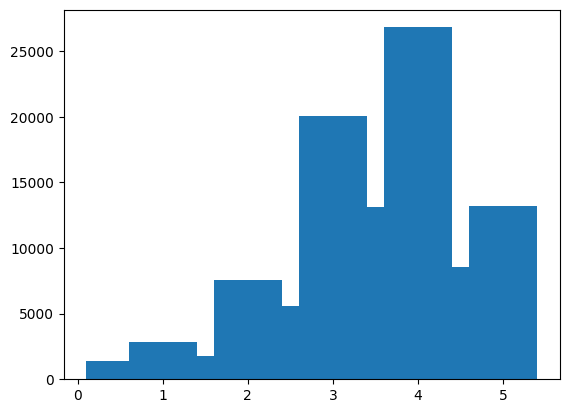

In [62]:
rating_dist = df.rating.value_counts()
print(rating_dist)
plt.bar(rating_dist.index, rating_dist.values)

#### Main

In [ ]:
class ItemDataset:
    def __init__(self, users, items, targets):
        self.users = users
        self.items = items
        self.targets = targets

    def __len__(self):
        return len(self.users)

    def __getitem__(self, item):
        users = self.users[item]
        items = self.items[item]
        targets = self.targets[item]

        return {
            "users": torch.tensor(users, dtype=torch.long),
            "items": torch.tensor(items, dtype=torch.long),
            "targets": torch.tensor(targets, dtype=torch.long),
        }

class 